In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2 
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 9.664590835571289 seconds


# Optimize Initial Velocity Field for Target Positions

<Figure size 216x216 with 1 Axes>

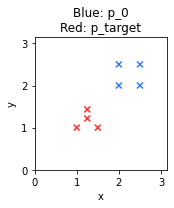

In [28]:
def init_p_with_target():
    # Rectangle [1,1]:[1.5,1.5]
    p_0 = math.tensor([
        [1.0, 1.0],
        [1.0, 1.5],
        [1.5, 1.0],
        [1.5, 1.5]], instance(i=4) & channel(vector='x,y')
    )
    p_target = math.tensor([
        [2.0, 2.0],
        [2.0, 2.5],
        [2.5, 2.0],
        [2.5, 2.5]], instance(i=4) & channel(vector='x,y')
    )
    p_triangle = math.tensor([
        [1.0 , 1.0],
        [1.25, 1.433],
        [1.25, 1.218],
        [1.5 , 1.0]], instance(i=4) & channel(vector='x,y')
    )
    #return (p_0, p_target)
    return(p_target, p_triangle)

p_0, p_target = init_p_with_target()

vis.plot({"Blue: p_0\nRed: p_target": vis.overlay(
    PointCloud(p_0, bounds=DOMAIN),
    PointCloud(p_target, bounds=DOMAIN, color="red")
)}, size=(3,3))

In [29]:
STEPS = 32
DT    = 0.2
VISCOSITY = 0.05

def loss_function(w, p, p_target):
    eigenfluid.w = w
    trajectory_p = [p]
    for i in range(STEPS-1):
        # Step velocity
        eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT, viscosity=VISCOSITY)
        # Get velocities at new positions
        p_velocities = eigenfluid.get_phi_at(p)
        # Midpoint
        #p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
        # Euler step for points
        p += p_velocities * DT
        trajectory_p.append(p)
    loss = field.l2_loss(p - p_target)
    return (loss, trajectory_p)

gradient_function = math.gradient(loss_function)

In [30]:
# Initialize w to some value for optimization (random or 0)
w_init = math.zeros_like(eigenfluid.w) + 0.001
#w_init = math.random_normal(eigenfluid.w.shape)
p_0, p_target = init_p_with_target()

# first gradient
(loss, trajectory_p), grad = gradient_function(w_init, p_0, p_target)
print("Initial Loss: {}".format(loss))

Initial Loss: 4.5623393


In [34]:
LR = 10**-1

w_optim = w_init
grads = []
for optim_step in range(81):
    (loss, trajectory_p), grad = gradient_function(w_optim, p_0, p_target)
    if optim_step%5 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    if optim_step == 51: 
        LR /= 2
        print("LR = {}".format(LR))
        
    grads.append( grad[0] )
    
    w_optim = w_optim - LR * grads[-1]

Optimization step 0, loss: 4.562339
Optimization step 1, loss: 0.826322
Optimization step 2, loss: 0.176565
Optimization step 3, loss: 0.159076
Optimization step 4, loss: 0.151901
Optimization step 5, loss: 0.147085
Optimization step 10, loss: 0.132642
Optimization step 15, loss: 0.122764
Optimization step 20, loss: 0.115056
Optimization step 25, loss: 0.109090
Optimization step 30, loss: 0.104491
Optimization step 35, loss: 0.100923
Optimization step 40, loss: 0.098113
Optimization step 45, loss: 0.095856
Optimization step 50, loss: 0.094002
LR = 0.05
Optimization step 55, loss: 0.093039
Optimization step 60, loss: 0.092306
Optimization step 65, loss: 0.091626
Optimization step 70, loss: 0.090991
Optimization step 75, loss: 0.090396
Optimization step 80, loss: 0.089835


### Plot Results of Optimization

In [35]:
trajectory_p = math.stack(trajectory_p, batch('time'))
target_time = math.stack([p_target]*STEPS, batch('time'))

#trajectory_v = math.stack(trajectory_v, batch('time'))
#trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

#velocity_field = math.stack([eigenfluid.reconstruct_velocity()]*STEPS, batch('time'))

vis.plot(vis.overlay(PointCloud(trajectory_p, bounds=DOMAIN),
                     PointCloud(target_time, bounds=DOMAIN, color="red")
                    ),
        animate='time',
        same_scale=False,
        size=(4,4)
)

<Figure size 432x288 with 0 Axes>

# Compare Results with Advection of Smoke Marker

In [36]:
def init_smoke():
    smoke = CenteredGrid(
        Box(x=[p_0.i[0]['x'], p_0.i[3]['x']], y=[p_0.i[0]['y'], p_0.i[1]['y']]), 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

In [37]:
eigenfluid.w = w_optim

velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()

vel_traj = [velocity]
w_traj = [eigenfluid.w]
smoke_traj = [smoke]

start_time = time.time()
for i in range(STEPS-1):
    # Simulate
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT, viscosity=VISCOSITY)
    velocity = eigenfluid.reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)
    # Save trajectory
    vel_traj.append(velocity)
    w_traj.append(eigenfluid.w)
    smoke_traj.append(smoke)
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

Simulation finished in 3.2880070209503174 seconds


In [38]:
trajectory_v = math.stack(vel_traj, batch('time'))
#trajectory_curl = math.stack(trajectory_curl, batch('time'))
trajectory_smoke = math.stack(smoke_traj, batch('time'))
trajectory_w = math.stack(list(map(get_w_point_cloud, [w*10 for w in w_traj])), batch('time'))

vis.plot({
    "Blue points: simulated points\nRed points: target points\nOverlayed with independent\nhigh-res smoke sim.": vis.overlay(PointCloud(trajectory_p, bounds=DOMAIN),
                PointCloud(target_time, bounds=DOMAIN, color="red"),
                trajectory_smoke
    ), 
    "Velocity Field": trajectory_v,
    "w basis coefficients \n(*10 for visualization)": trajectory_w
}, animate='time', same_scale=False)

<Figure size 432x288 with 0 Axes>